In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd
link_hilstrom = 'https://drive.google.com/open?id=15osyN4c5z1pSo1JkxwL_N8bZTksRvQuU'
fluff, id = link_hilstrom.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Hillstrom.csv')
hillstrom_df = pd.read_csv('Hillstrom.csv')

In [0]:
import pandas as pd
link_lalonde = 'https://drive.google.com/open?id=1b8N7WtwIe2WmQJD1KL5UAy70K13MxwKj'
fluff, id = link_lalonde.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Lalonde.csv')
lalonde_df = pd.read_csv('Lalonde.csv')

In [0]:
import pandas as pd
link_criteo = 'https://drive.google.com/open?id=1Vxv7JiEyFr2A99xT6vYzB5ps5WhvV7NE'
fluff, id = link_criteo.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('criteo_small.csv')
criteo_df = pd.read_csv('criteo_small.csv')

In [0]:
link_criteo_fix = 'https://drive.google.com/open?id=13pNFAeH1ZEPxaCU9tQz1H17L28aTcppg'
fluff, id = link_criteo_fix.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('criteo_small_fix.csv')
criteo_df = pd.read_csv('criteo_small_fix.csv')

In [0]:
import csv
import json
import os
from os.path import isfile, join
from sklearn.model_selection import KFold, StratifiedKFold


def preprocess_data(df, dataset='hillstrom', verbose=True):
    # For Hillstrom dataset, the ‘‘visit’’ target variable was selected
    #   as the target variable of interest and the selected treatment is 
    #   the e-mail campaign for women’s merchandise [1]
    # [1] Kane K, Lo VSY, Zheng J. True-lift modeling: Comparison of methods. 
    #    J Market Anal. 2014;2:218–238
    dataset = dataset.lower()
    if dataset in ('hillstrom', 'email'):
        columns = df.columns
        for col in columns:
            if df[col].dtype != object:
                continue
            df = pd.concat(
                    [df, pd.get_dummies(df[col], 
                                        prefix=col, 
                                        drop_first=False)],
                    axis=1)
            df.drop([col], axis=1, inplace=True)

        df.columns = [col.replace('-', '').replace(' ', '_').lower()
                      for col in df.columns]
        df = df[df.segment_mens_email == 0]
        df.index = range(len(df))
        df.drop(['segment_mens_email', 
                 'segment_no_email', 
                 'conversion', 
                 'spend'], axis=1, inplace=True)

        y_name = 'visit'
        t_name = 'segment_womens_email'
    elif dataset in ['criteo', 'ad']:
        df = df.fillna(0)
        y_name = 'y'
        t_name = 'treatment'
    elif dataset == 'lalonde':
        y_name = 'RE78'
        t_name = 'treatment'
    else:
        raise NotImplementedError
    
    df['Y'] = df[y_name]
    df.drop([y_name], axis=1, inplace=True)
    df['T'] = df[t_name]
    df.drop([t_name], axis=1, inplace=True)
    
    return df

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def performance(pr_y1_t1, pr_y1_t0, y, t, groups=10):
    """
    1. Split the total customers into the given number of groups
    2. Calculate the statistics of each segment
    
    Args:
        pr_y1_t1: the series (list) of the customer's expected return
        pr_y1_t0: the expected return when a customer is not treated
        y: the observed return of customers
        t: whther each customer is treated or not
        groups: the number of groups (segments). Should be 5, 10, or 20
    Return:
        DataFrame:
            columns:
                'n_y1_t1': the number of treated responders
                'n_y1_t0': the number of not treated responders
                'r_y1_t1': the average return of treated customers
                'r_y1_t0': the average return of not treated customers
                'n_t1': the number of treated customers
                'n_t0': the number of not treated customers
                'uplift': the average uplift (the average treatment effect)
            rows: the index of groups
    """
  
    ### check valid arguments
    if groups not in [5, 10, 20]:
        raise Exception("uplift: groups must be either 5, 10 or 20")
  
    ### check for NAs.
    if pr_y1_t1.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_t1")
    if pr_y1_t0.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_t0")
    if y.isnull().values.any():
        raise Exception("uplift: NA not permitted in y")
    if t.isnull().values.any():
        raise Exception("uplift: NA not permitted in t")
   
    ### check valid values for y and t
    # if set(y) != {0, 1}:
    #     raise Exception("uplift: y must be either 0 or 1")
    if set(t) != {0, 1}:
        raise Exception("uplift: t must be either 0 or 1")

    ### check length of arguments
    if not (len(pr_y1_t1) == len(pr_y1_t0) == len(y) == len(t)):
        raise Exception("uplift: arguments pr_y1_t1, pr_y1_t0, y and t must all have the same length")

    ### define dif_pred
    dif_pred = pr_y1_t1 - pr_y1_t0
  
    ### Make index same
    y.index = dif_pred.index
    t.index = dif_pred.index
    
    mm = pd.DataFrame({
        'dif_pred': dif_pred,
        'y': y,
        't': t,
        'dif_pred_r': dif_pred.rank(ascending=False, method='first')
    })

    mm_groupby = mm.groupby(pd.qcut(mm['dif_pred_r'], groups, labels=range(1, groups+1), duplicates='drop'))
  
    n_y1_t1 = mm_groupby.apply(lambda r: r[r['t'] == 1]['y'].sum())
    n_y1_t0 = mm_groupby.apply(lambda r: r[r['t'] == 0]['y'].sum())
    n_t1 = mm_groupby['t'].sum()
    n_t0 = mm_groupby['t'].count() - n_t1
  
    df = pd.DataFrame({
        'n_t1': n_t1,
        'n_t0': n_t0,
        'n_y1_t1': n_y1_t1,
        'n_y1_t0': n_y1_t0,
        'r_y1_t1': n_y1_t1 / n_t1,
        'r_y1_t0': n_y1_t0 / n_t0,
    })
    fillna_columns = ['n_y1_t1', 'n_y1_t0', 'n_t1', 'n_t0']
    df[fillna_columns] = df[fillna_columns].fillna(0)
    df.index.name = 'groups'

    df['uplift'] = df['r_y1_t1'] - df['r_y1_t0']
    df['uplift'] = round(df['uplift'], 6)

    return df


def qini(perf, plotit=True):
    nrow = len(perf)

    # Calculating the incremental gains. 
    # - First, the cumulitative sum of the treated and the control groups are
    #  calculated with respect to the total population in each group at the
    #  specified decile
    # - Afterwards we calculate the percentage of the total amount of people
    #  (both treatment and control) are present in each decile
    cumul_y1_t1 = (perf['n_y1_t1'].cumsum() / perf['n_t1'].cumsum()).fillna(0)
    cumul_y1_t0 = (perf['n_y1_t0'].cumsum() / perf['n_t0'].cumsum()).fillna(0)
    deciles = [i/nrow for i in range(1, nrow+1)]

    ### Model Incremental gains
    inc_gains = (cumul_y1_t1 - cumul_y1_t0) * deciles
    inc_gains = [0.0] + list(inc_gains)

    ### Overall incremental gains
    overall_inc_gain = sum(perf['n_y1_t1']) / sum(perf['n_t1']) \
            - sum(perf['n_y1_t0']) / sum(perf['n_t0'])

    ### Random incremental gains
    random_inc_gains = [i*overall_inc_gain / nrow for i in range(nrow+1)]

    ### Compute area under the model incremental gains (uplift) curve
    x = [0] + deciles
    y = list(inc_gains)
    auuc = 0
    auuc_rand = 0

    auuc_list = [auuc]
    for i in range(1, len(x)):
        auuc += 0.5 * (x[i] - x[i-1]) * (y[i] + y[i-1])
        auuc_list.append(auuc)

    ### Compute area under the random incremental gains curve
    y_rand = random_inc_gains

    auuc_rand_list = [auuc_rand]
    for i in range(1, len(x)):
        auuc_rand += 0.5 * (x[i] - x[i-1]) * (y_rand[i] + y_rand[i-1])
        auuc_rand_list.append(auuc_rand)

    ### Compute the difference between the areas (Qini coefficient)
    Qini = auuc - auuc_rand

    ### Plot incremental gains curve
    if plotit:
        x_axis = x
        plt.plot(x_axis, inc_gains)
        plt.plot(x_axis, random_inc_gains)
        plt.show()
    
    ### Qini 30%, Qini 10%
    n_30p = int(nrow*3/10)
    n_10p = int(nrow/10)
    qini_30p = auuc_list[n_30p] - auuc_rand_list[n_30p]
    qini_10p = auuc_list[n_10p] - auuc_rand_list[n_10p]

    res = {
        'qini': Qini,
        'inc_gains': inc_gains,
        'random_inc_gains': random_inc_gains,
        'auuc_list': auuc_list,
        'auuc_rand_list': auuc_rand_list,
        'qini_30p': qini_30p,
        'qini_10p': qini_10p,
    }    

    return res


In [0]:
import itertools
import numpy as np

def parameter_tuning(fit_mdl, pred_mdl, data, search_space, plotit=False):
    """
    Given a model, search all combination of parameter sets and find
    the best parameter set
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "t_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "t_test": treatment variables of test (usually, validation) dataset,
            }
        search_space:
            {
                parameter_name: [search values]
            }
    Return:
        The best parameter set
    """
    x_train = data['x_train']
    y_train = data['y_train']
    t_train = data['t_train']
    x_test = data['x_test']
    y_test = data['y_test']
    t_test = data['t_test']
    
    max_q = -float('inf')
    best_mdl = None

    keys = search_space.keys()
    n_space = [len(search_space[key]) for key in keys]
    n_iter = np.prod(n_space)
    
    best_params = None
    for i in range(n_iter):
        params = {}
        for idx, key in enumerate(keys):
            params[key] = search_space[key][i % n_space[idx]]
            i = int(i / n_space[idx])

        mdl = fit_mdl(x_train, y_train, t_train, **params)
        pred = pred_mdl(mdl, newdata=x_test, y=y_test, ct=t_test)
        # print('    {}'.format(params))
        try:
            perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
        except Exception as e:
            print(e)
            continue
        q = qini(perf, plotit=plotit)['qini']
        if plotit:
            print(q, params)
        if q > max_q:
            max_q = q
            best_mdl = mdl
            best_params = params

    return best_mdl, best_params


def wrapper(fit_mdl, pred_mdl, data, params=None,
            best_models=None, drop_variables=None, qini_values=None):
    """
    General wrapper approach
    
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "t_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "t_test": treatment variables of test (usually, validation) dataset,
            }
    Return:
        (A list of best models, The list of dropped variables)
    """
    if best_models is None:
        best_models = []
    if drop_variables is None:
        drop_variables = []
    if qini_values is None:
        qini_values = []
    if params is None:
        params = {}

    x_train = data['x_train']
    y_train = data['y_train']
    t_train = data['t_train']
    x_test = data['x_test']
    y_test = data['y_test']
    t_test = data['t_test']

    variables = data['x_train'].columns

    max_q = -float('inf')
    drop_var = None
    best_mdl = None
    for var in variables:
        if var in drop_variables:
            continue
        x = x_train.copy()
        x.drop(drop_variables + [var], axis=1, inplace=True)
        mdl = fit_mdl(x, y_train, t_train, **params)
        x = x_test.copy()
        x.drop(drop_variables + [var], axis=1, inplace=True)
        pred = pred_mdl(mdl, newdata=x, y=y_test, ct=t_test)
        perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
        q = qini(perf, plotit=False)['qini']
        if q > max_q:
            max_q = q
            drop_var = var
            best_mdl = mdl
    
    best_models.append(best_mdl)
    drop_variables.append(drop_var)
    qini_values.append(max_q)

    left_vars = [var for var in variables if (var not in drop_variables)]
    
    if len(variables) == len(drop_variables) + 1:
        return best_models, drop_variables + left_vars, qini_values
    else:
        return wrapper(fit_mdl, pred_mdl, data, params=params,
                       best_models=best_models, drop_variables=drop_variables,
                       qini_values=qini_values)



In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


def tma(x, y, t, method=LogisticRegression, **kwargs):
    """Training a model according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    The default model is General Linear Model (GLM)
    
    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        t: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        Dictionary: A dictionary of two models. One for the treatment group, 
            one for the control group.

            {
                'model_treat': a model for the treatment group,
                'model_control': a model for the control group
            }

    """
    
    treat_rows = (t == 1)
    control_rows = (t == 0)
    model_treat = method(**kwargs).fit(x[treat_rows], y[treat_rows])
    model_control = method(**kwargs).fit(x[control_rows], y[control_rows])
    
    res = {
        'model_treat': model_treat,
        'model_control': model_control,
    }
    return res


def predict_tma(obj, newdata, **kwargs):
    """Predictions according to the "Two Model Approach" 
    (a.k.a. "Separate Model Approach")
    
    For each instance in newdata two predictions are made:
    1) What is the probability of a person responding when treated?
    2) What is the probability of a person responding when not treated
      (i.e. part of control group)?

    Source: "Incremental Value Modeling" (Hansotia, 2002)

    Args:
        obj: A dictionary of two models. 
            One for the treatment group, one for the control group.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        DataFrame: A dataframe with predicted returns for when the customers
            are treated and for when they are not treated.
    """
   
    if isinstance(obj['model_treat'], LinearRegression):
        pred_treat = obj['model_treat'].predict(newdata)
    else:
        pred_treat = obj['model_treat'].predict_proba(newdata)[:, 1]

    if isinstance(obj['model_control'], LinearRegression):
        pred_control = obj['model_control'].predict(newdata)
    else:
        pred_control = obj['model_control'].predict_proba(newdata)[:, 1]
    
    # pred_treat = obj['model_treat'].predict(newdata)
    # pred_control = obj['model_control'].predict(newdata)
    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df



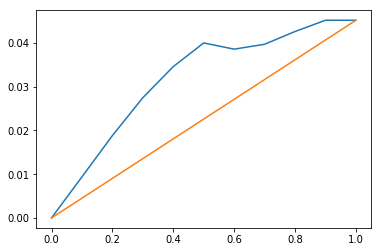

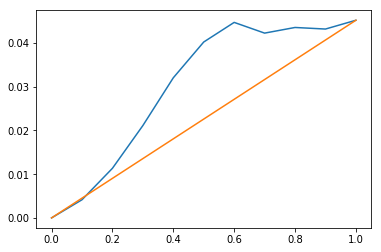

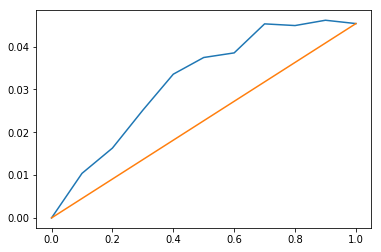

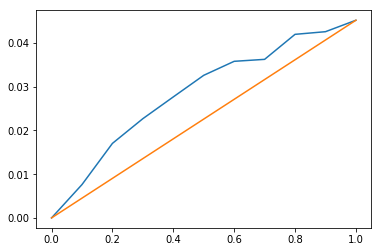

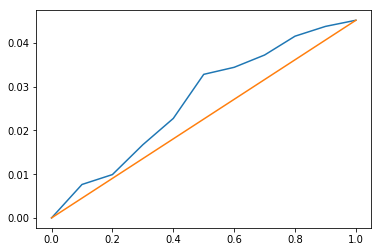

Qini values:  [0.00930298159369413, 0.0079143741075417, 0.009362800609373716, 0.0060846682627555965, 0.004351504177646202]
    mean: 0.007403265750202269, std: 0.0019371048981867154
Qini values:  [0.002162906722287846, 0.0005708951949176906, 0.0018870117621176668, 0.001566579469263145, 0.0005586900241286064]
    mean: 0.001349216634542991, std: 0.00010625188069440285
Qini values:  [0.00024384640794335307, -1.8358574659426682e-05, 0.0002932306931228293, 0.00015511752659574113, 0.00015635152795707784]
    mean: 0.001349216634542991, std: 0.00010625188069440285


In [0]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold


def ty_assign(y, t):
    if y == 1 and t == 1:
        return "TR"
    elif y == 0 and t == 1:
        return "TN"
    elif y == 1 and t == 0:
        return "CR"
    elif y == 0 and t == 0:
        return "CN"
    else:
        return None


def t_assign(ty):
    if ty in ("TR", "TN"):
        return 1
    elif ty in ("CR", "CN"):
        return 0
    else:
        return None


def y_assign(ty):
    if ty in ("TR", "CR"):
        return 1
    elif ty in ("TN", "CN"):
        return 0
    else:
        return None

search_space = {
    'method': [LogisticRegression],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'penalty': ['none', 'l2'],
    'tol': [1e-2, 1e-3, 1e-4],
    'C': [1e6, 1e3, 1, 1e-3, 1e-6],
}

def main():
    ### Load data ###
    df = pd.read_csv('Hillstrom.csv')
    dataset = 'hillstrom'
    df = preprocess_data(df)
    Y = df['Y']
    T = df['T']
    X = df.drop(['Y', 'T'], axis=1)
    ty = pd.DataFrame({'Y': Y, 'T': T})\
             .apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)
    if dataset == 'hillstrom':
        fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)
    elif dataset == 'lalonde':
        fold_gen = KFold(n_splits=5, shuffle=True, random_state=1234).split(X)
    else:
        pass


    ### Cross validation ###
    qini_list = []
    qini_30_list = []
    qini_10_list = []
    
    for idx, (train_index, test_index) in enumerate(fold_gen):
        X_train = X.reindex(train_index)
        X_test = X.reindex(test_index)
        Y_train = Y.reindex(train_index)
        Y_test = Y.reindex(test_index)
        T_train = T.reindex(train_index)
        T_test = T.reindex(test_index)

        #df = X_train.copy()
        #df['Y'] = Y_train
        #df['T'] = T_train
        #stratify = T_train
        #if dataset == 'hillstrom':
        #    stratify = df[['Y', 'T']]
        #tuning_df, validate_df = train_test_split(
        #    df, test_size=0.33, random_state=1234, stratify=stratify)

        #X_tuning = tuning_df.drop(['Y', 'T'], axis=1)
        #Y_tuning = tuning_df['Y']
        #T_tuning = tuning_df['T']

        #X_validate = validate_df.drop(['Y', 'T'], axis=1)
        #Y_validate = validate_df['Y']
        #T_validate = validate_df['T']
        
        #data_dict = {
        #    "x_train": X_tuning,
        #    "y_train": Y_tuning,
        #    "t_train": T_tuning,
        #    "x_test": X_validate,
        #    "y_test": Y_validate,
        #    "t_test": T_validate,
        #}
        
        #model_method = search_space.get('method', None)
        #params = {
        #    'method': None if model_method is None else model_method[0],
        #}
        #if params['method'] == LogisticRegression:
        #    solver = search_space.get('solver', None)
        #    params['solver'] = None if solver is None else solver[0]

        #_, drop_vars, qini_values = wrapper(
        #        tma, predict_tma, data_dict, params=params)
        #best_qini = max(qini_values)
        #best_idx = qini_values.index(best_qini)
        #best_drop_vars = drop_vars[:best_idx]

        #X_tuning.drop(best_drop_vars, axis=1, inplace=True)
        #X_validate.drop(best_drop_vars, axis=1, inplace=True)
        #X_train.drop(best_drop_vars, axis=1, inplace=True)
        #X_test.drop(best_drop_vars, axis=1, inplace=True)

        #_, best_params = parameter_tuning(tma, predict_tma, data_dict, 
        #                                  search_space=search_space)
        best_params = {}
        mdl = uplift_tree(X_train, Y_train, T_train, **best_params)
        pred = predict_tree(mdl, X_test)
        perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
        q = qini(perf)
        qini_list.append(q['qini'])
        qini_30_list.append(q['qini_30p'])
        qini_10_list.append(q['qini_10p'])
    print('Qini values: ', qini_list)
    print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))
    print('Qini values: ', qini_30_list)
    print('    mean: {}, std: {}'.format(np.mean(qini_30_list), np.std(qini_10_list)))
    print('Qini values: ', qini_10_list)
    print('    mean: {}, std: {}'.format(np.mean(qini_30_list), np.std(qini_10_list)))
    
main()


In [0]:
import sys
import numpy as np
import random
import math

import warnings
warnings.filterwarnings("ignore")

class Node(object):
    def __init__(self, attribute, threshold):
        self.attr = attribute
        
        self.thres = threshold
        self.left = None
        self.right = None
        self.leaf = False
        self.predict = None, None


def info_gain(df, attribute, predict_attr, treatment_attr,
              method, min_bucket_t0, min_bucket_t1):
    """
    Select the information gain and threshold of the attribute to split
    The threshold chosen splits the test data such that information gain is maximized
    
    Return a pandas.DataFrame
        columns: 'thres' (threshold) and 'info_gain' (information gain)
    """
    num_total = df.shape[0]
    tmp = pd.DataFrame({
        'thres': df[attribute],
        'Y': df[predict_attr],
        'T': df[treatment_attr]
    })
    tmp.sort_values(['thres'], inplace=True)

    tmp['n_t1_L'] = (tmp['T']).cumsum()
    tmp['n_t0_L'] = (tmp['T'] == 0).cumsum()
    tmp['n_t1_R'] = sum(tmp['T']) - (tmp['T']).cumsum()
    tmp['n_t0_R'] = sum(tmp['T'] == 0) - (tmp['T'] == 0).cumsum()
    tmp['n_y_t1_L'] = (tmp['T'] & tmp['Y']).cumsum()
    tmp['n_y_t0_L'] = ((tmp['T'] == 0) & tmp['Y']).cumsum()
    tmp['n_y_t1_R'] = sum(tmp['T'] & tmp['Y']) - (tmp['T'] & tmp['Y']).cumsum()
    tmp['n_y_t0_R'] = sum((tmp['T'] == 0) & tmp['Y']) - ((tmp['T'] == 0) & tmp['Y']).cumsum()
        
    # min bucket condition
    #   Check the size of treatment & control group in left & right child
    tmp['min_bucket_ok'] = ((tmp['n_t1_L'] >= min_bucket_t1) & 
                            (tmp['n_t0_L'] >= min_bucket_t0) &
                            (tmp['n_t1_R'] >= min_bucket_t1) &
                            (tmp['n_t0_R'] >= min_bucket_t0))
    
    if sum(tmp['min_bucket_ok']) > 0:
        num_total = df.shape[0]
        tr, tn, cr, cn = num_class(df, predict_attr, treatment_attr)
        n_t1 = tr + tn
        n_t0 = cr + cn
        pr_t1 = (tr + tn) / (num_total)
        # r_t0 = (tr + cr) / (num_total)
        pr_t0 = 1 - pr_t1
        pr_y1_t1 = tr / (tr + tn)
        pr_y1_t0 = cr / (cr + cn)

        # Randomized assignment implies pr_l_t1 = pr_l_t0 for all possible splits
        pr_l_t1 = (tmp['n_t1_L']) / (n_t1)
        pr_l_t0 = (tmp['n_t0_L']) / (n_t0)
        pr_l = pr_l_t1 * pr_t1 + pr_l_t0 * pr_t0
        pr_r = 1 - pr_l

        # Add Laplace correction to probablities
        pr_y1_l_t1 = (tmp['n_y_t1_L']) / (tmp['n_t1_L'])
        pr_y1_l_t0 = (tmp['n_y_t0_L']) / (tmp['n_t0_L'])
        pr_y1_r_t1 = (tmp['n_y_t1_R']) / (tmp['n_t1_R'])
        pr_y1_r_t0 = (tmp['n_y_t0_R']) / (tmp['n_t0_R'])

        # Number of treatment/control observations at left and right child nodes
        n_t1_L = tmp['n_t1_L']
        n_t0_L = tmp['n_t0_L']
        n_t1_R = tmp['n_t1_R']
        n_t0_R = tmp['n_t0_R']

        if method.lower() == 'ed':
            tmp['info_gain'] = eucli_dist(tmp,
                                          pr_y1_t1,
                                          pr_y1_t0,
                                          pr_l,
                                          pr_r,
                                          pr_y1_l_t1,
                                          pr_y1_l_t0,
                                          pr_y1_r_t1,
                                          pr_y1_r_t0,
                                          pr_t1,
                                          pr_t0,
                                          pr_l_t1,
                                          pr_l_t0)
        elif method.lower() == 'kl':
            tmp['info_gain'] = kl_divergence(tmp,
                                            pr_y1_t1,
                                            pr_y1_t0,
                                            pr_l,
                                            pr_r,
                                            pr_y1_l_t1,
                                            pr_y1_l_t0,
                                            pr_y1_r_t1,
                                            pr_y1_r_t0,
                                            pr_t1,
                                            pr_t0,
                                            pr_l_t1,
                                            pr_l_t0)
        elif method.lower() == 'chisq':
            tmp['info_gain'] = chisq(tmp,
                                    pr_y1_t1,
                                    pr_y1_t0,
                                    pr_l,
                                    pr_r,
                                    pr_y1_l_t1,
                                    pr_y1_l_t0,
                                    pr_y1_r_t1,
                                    pr_y1_r_t0,
                                    pr_t1,
                                    pr_t0,
                                    pr_l_t1,
                                    pr_l_t0)
        elif method.lower() == 'int':
            tmp['info_gain'] = interaction_split(tmp,
                                                pr_y1_t1,
                                                pr_y1_t0,
                                                pr_l,
                                                pr_r,
                                                pr_y1_l_t1,
                                                pr_y1_l_t0,
                                                pr_y1_r_t1,
                                                pr_y1_r_t0,
                                                pr_t1,
                                                pr_t0,
                                                pr_l_t1,
                                                pr_l_t0,
                                                n_t1_L,
                                                n_t0_L,
                                                n_t1_R,
                                                n_t0_R)
        else:
            raise NotImplementedError
    
    # We will select one rows per one distinct candidate
    tmp['dups'] = tmp['thres'].duplicated(keep='last')
    tmp['thres_ok'] = (tmp['min_bucket_ok'] & (tmp['dups'] == False))
    tmp.dropna(inplace=True)
    if sum(tmp['thres_ok']) < 1:
        return None

    tmp = tmp[tmp['thres_ok']]

    return tmp[['thres', 'info_gain']]
    


def num_class(df, predict_attr, treatment_attr):
    """
    Returns the number of Responders and Non-responders in Treatment and Control group
    """
    tr = df[(df[predict_attr] == 1) & (df[treatment_attr] == 1)]  # Responders in Treatment group
    tn = df[(df[predict_attr] == 0) & (df[treatment_attr] == 1)]  # Non-responders in Treatment group
    cr = df[(df[predict_attr] == 1) & (df[treatment_attr] == 0)]  # Responders in Control group
    cn = df[(df[predict_attr] == 0) & (df[treatment_attr] == 0)]  # Non-responders in Control group
    return tr.shape[0], tn.shape[0], cr.shape[0], cn.shape[0]


def choose_attr(df, attributes, predict_attr, treatment_attr,
                method, min_bucket_t0, min_bucket_t1):
    """
    Chooses the attribute and its threshold with the highest info gain
    from the set of attributes
    """
    max_info_gain = 0
    best_attr = None
    threshold = None
    # Test each attribute (note attributes maybe be chosen more than once)
    for attr in attributes:
        df_ig = info_gain(df, attr, predict_attr, treatment_attr,
                          method, min_bucket_t0, min_bucket_t1)
        if df_ig is None:
            continue

        # Get the possible indices of maximum info gain
        ig = max(df_ig['info_gain'])
        idx_ig = df_ig.index[df_ig['info_gain']==ig]
        # Break ties randomly
        idx_ig = random.choice(idx_ig)
        # Get information gain & threshold of that
        thres = df_ig['thres'][idx_ig]

        if ig > max_info_gain:
            max_info_gain = ig
            best_attr = attr
            threshold = thres
    return best_attr, threshold


def build_tree(df, cols, predict_attr='Y', treatment_attr='T',
               method='ED', depth=1, max_depth=float('INF'),
               min_split=2000, min_bucket_t0=None, min_bucket_t1=None,
               mtry=None, random_seed=1234):
    """
    Builds the Decision Tree based on training data, attributes to train on,
    and a prediction attribute
    """
    if depth == 1:
        np.random.seed(random_seed)
    
    if mtry is None:
        mtry = math.floor(math.sqrt(len(cols)))
    if min_bucket_t0 is None:
        min_bucket_t0 = round(min_split/4)
    if min_bucket_t1 is None:
        min_bucket_t1 = round(min_split/4)
    
    # Get the number of positive and negative examples in the training data
    tr, tn, cr, cn = num_class(df, predict_attr, treatment_attr)
    r_y1_ct1 = tr / (tr + tn)
    r_y1_ct0 = cr / (cr + cn)

    # Check varialbes have less than 2 levels at the current node
    # If not, exclude them as candidates for mtry selection
    # To split the node, sum(ok_vars) should be equal or larger than self.mtry
    ok_vars = []
    for col in cols:
        ok_vars.append(len(set(df[col])) > 1)

    # Whether we have to split this node
    #   1. min split condition: Both the sizes of treatment and control group 
    #     of an internal node should be larger than 'min_split'
    #   2. max depth condition: The depth of tree is 'max_depth'
    #   3. min_bucket condition: The number of treatment/control group of a
    #     node should be larger than 'min_bucket_t0'/'min_bucket_t1'
    #   4. Expected return should be larger than 0 and smaller than 1
    #     (for KL-divergence & Chisq splitting criteria)
    split_cond = tr + tn > min_split and cr + cn > min_split \
            and 0 < r_y1_ct1 < 1 and 0 < r_y1_ct0 < 1 \
            and depth < max_depth and sum(ok_vars) >= mtry
    
    best_attr, threshold = None, None
    if split_cond:
        # Sample columns
        ok_cols = [col for col in cols if len(set(df[col])) > 1]
        ok_cols = np.random.choice(ok_cols, mtry, replace=False)
        # Determine attribute and its threshold value with the highest
        # information gain
        best_attr, threshold = choose_attr(df, ok_cols, predict_attr, treatment_attr,
                                           method, min_bucket_t0, min_bucket_t1)
    if best_attr is None:
        # Create a leaf node indicating it's prediction
        leaf = Node(None,None)
        leaf.leaf = True
        leaf.predict = (tr / (tr + tn), cr / (cr + cn))
        return leaf
    else:
        # Create internal tree node based on attribute and it's threshold
        sub_1 = df[df[best_attr] <= threshold]
        sub_2 = df[df[best_attr] > threshold]
        sub1_tr, sub1_tn, sub1_cr, sub1_cn = num_class(sub_1, predict_attr, treatment_attr)
        sub2_tr, sub2_tn, sub2_cr, sub2_cn = num_class(sub_2, predict_attr, treatment_attr)
        tree = Node(best_attr, threshold)
        # Recursively build left and right subtree
        tree.left = build_tree(sub_1, cols, predict_attr, treatment_attr,
                               method=method, depth=depth+1, max_depth=max_depth,
                               min_split=min_split, min_bucket_t0=min_bucket_t0, 
                               min_bucket_t1=min_bucket_t1, mtry=mtry)
        tree.right = build_tree(sub_2, cols, predict_attr, treatment_attr,
                               method=method, depth=depth+1, max_depth=max_depth,
                               min_split=min_split, min_bucket_t0=min_bucket_t0, 
                               min_bucket_t1=min_bucket_t1, mtry=mtry)
        return tree


def predict(node, row_df):
    """
    Given a instance of a training data, make a prediction of an observation (row)
    based on the Decision Tree
    Assumes all data has been cleaned (i.e. no NULL data)
    """
    # If we are at a leaf node, return the prediction of the leaf node
    if node.leaf:
        return node.predict
    # Traverse left or right subtree based on instance's data
    if row_df[node.attr] <= node.thres:
        return predict(node.left, row_df)
    elif row_df[node.attr] > node.thres:
        return predict(node.right, row_df)


def test_predictions(root, df):
    """
    Given a set of data, make a prediction for each instance using the Decision Tree
    """
    pred_treat = []
    pred_control = []
    for index,row in df.iterrows():
        return_treated, return_control = predict(root, row)
        pred_treat.append(return_treated)
        pred_control.append(return_control)
    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df




In [0]:
def eucli_dist(small_df,
               pr_y1_ct1,
               pr_y1_ct0,
               pr_l,
               pr_r,
               pr_y1_l_ct1,
               pr_y1_l_ct0,
               pr_y1_r_ct1,
               pr_y1_r_ct0,
               pr_ct1,
               pr_ct0,
               pr_l_ct1,
               pr_l_ct0):
    # Euclidean gain
    ed_node = (pr_y1_ct1 - pr_y1_ct0) ** 2 + ((1 - pr_y1_ct1) - (1 - pr_y1_ct0)) ** 2
    ed_l = (pr_y1_l_ct1 - pr_y1_l_ct0) ** 2 + ((1 - pr_y1_l_ct1) - (1 - pr_y1_l_ct0)) ** 2
    ed_r = (pr_y1_r_ct1 - pr_y1_r_ct0) ** 2 + ((1 - pr_y1_r_ct1) - (1 - pr_y1_r_ct0)) ** 2
    ed_lr = pr_l * ed_l + pr_r * ed_r
    ed_gain = ed_lr - ed_node

    # Euclidean Normalization factor
    gini_ct = 2 * pr_ct1 * (1 - pr_ct1)
    ed_ct = (pr_l_ct1 - pr_l_ct0) ** 2 + ((1 - pr_l_ct1) - (1 - pr_l_ct0)) ** 2
    gini_ct1 = 2 * pr_l_ct1 * (1 - pr_l_ct1)
    gini_ct0 = 2 * pr_l_ct0 * (1 - pr_l_ct0)
    ed_norm = gini_ct * ed_ct + gini_ct1 * pr_ct1 + gini_ct0 * pr_ct0 + 0.5
    
    # Output
    info_gain_t = ed_gain / ed_norm

    return info_gain_t


def kl_divergence(small_df,
                  pr_y1_ct1,
                  pr_y1_ct0,
                  pr_l,
                  pr_r,
                  pr_y1_l_ct1,
                  pr_y1_l_ct0,
                  pr_y1_r_ct1,
                  pr_y1_r_ct0,
                  pr_ct1,
                  pr_ct0,
                  pr_l_ct1,
                  pr_l_ct0):
    # KL Gain
    kl_node = pr_y1_ct1 * np.log2(pr_y1_ct1/pr_y1_ct0) + \
             (1 - pr_y1_ct1) * np.log2((1 - pr_y1_ct1) / (1 - pr_y1_ct0))
    kl_l = pr_y1_l_ct1 * np.log2(pr_y1_l_ct1 / pr_y1_l_ct0) + \
          (1 - pr_y1_l_ct1) * np.log2((1 - pr_y1_l_ct1) / (1 - pr_y1_l_ct0))
    kl_r = pr_y1_r_ct1 * np.log2(pr_y1_r_ct1 / pr_y1_r_ct0) + \
          (1 - pr_y1_r_ct1) * np.log2((1 - pr_y1_r_ct1) / (1 - pr_y1_r_ct0))
    kl_lr = pr_l * kl_l + pr_r * kl_r
    kl_gain = kl_lr - kl_node

    # KL Normalization factor
    ent_ct = -(pr_ct1 * np.log2(pr_ct1) + pr_ct0 * np.log2(pr_ct0))
    kl_ct = pr_l_ct1 * np.log2(pr_l_ct1 / pr_l_ct0) + \
           (1 - pr_l_ct1) * np.log2 ((1 - pr_l_ct1) / (1 - pr_l_ct0))
    ent_ct1 = -(pr_l_ct1 * np.log2(pr_l_ct1) + (1 - pr_l_ct1) * np.log2((1 - pr_l_ct1)))
    ent_ct0 = -(pr_l_ct0 * np.log2(pr_l_ct0) + (1 - pr_l_ct0) * np.log2((1 - pr_l_ct0)))

    norm = kl_ct * ent_ct + ent_ct1 * pr_ct1 + ent_ct0 * pr_ct0 + 0.5

    # Output
    info_gain_t = kl_gain / norm

    return info_gain_t


def chisq(small_df,
          pr_y1_ct1,
          pr_y1_ct0,
          pr_l,
          pr_r,
          pr_y1_l_ct1,
          pr_y1_l_ct0,
          pr_y1_r_ct1,
          pr_y1_r_ct0,
          pr_ct1,
          pr_ct0,
          pr_l_ct1,
          pr_l_ct0):
    # Chi-squared gain
    chisq_node = ((pr_y1_ct1 - pr_y1_ct0) ** 2) / pr_y1_ct0 + \
                (((1 - pr_y1_ct1) - (1 - pr_y1_ct0)) ** 2) / (1 - pr_y1_ct0) 
    chisq_l = ((pr_y1_l_ct1 - pr_y1_l_ct0) ** 2) / pr_y1_l_ct0 + \
             (((1 - pr_y1_l_ct1) - (1 - pr_y1_l_ct0)) ** 2) / (1 - pr_y1_l_ct0)
    chisq_r = ((pr_y1_r_ct1 - pr_y1_r_ct0) ** 2) / pr_y1_r_ct0 + \
             (((1 - pr_y1_r_ct1) - (1 - pr_y1_r_ct0)) ** 2) / (1 - pr_y1_r_ct0)
    chisq_lr = pr_l * chisq_l + pr_r * chisq_r
    chisq_gain = chisq_lr - chisq_node

    # Chi-squared Normalization factor
    gini_ct = 2 * pr_ct1 * (1 - pr_ct1) 
    chisq_ct = ((pr_l_ct1 - pr_l_ct0) ** 2) / pr_l_ct0 + \
              (((1 - pr_l_ct1) - (1 - pr_l_ct0)) ** 2) / (1 - pr_l_ct0)
    gini_ct1 = 2 * pr_l_ct1 * (1 - pr_l_ct1)
    gini_ct0 = 2 * pr_l_ct0 * (1 - pr_l_ct0)
    chisq_norm = gini_ct * chisq_ct + gini_ct1 * pr_ct1  + gini_ct0 * pr_ct0 + 0.5
     
    # Output
    info_gain_t = chisq_gain / chisq_norm

    return info_gain_t


def interaction_split(small_df,
                      pr_y1_ct1,
                      pr_y1_ct0,
                      pr_l,
                      pr_r,
                      pr_y1_l_ct1,
                      pr_y1_l_ct0,
                      pr_y1_r_ct1,
                      pr_y1_r_ct0,
                      pr_ct1,
                      pr_ct0,
                      pr_l_ct1,
                      pr_l_ct0,
                      cs_ct1,
                      cs_ct0,
                      ncs_ct1,
                      ncs_ct0):
    # Compute elements for split formula
    C44 = 1/cs_ct1 + 1/cs_ct0 + 1/ncs_ct1 + 1/ncs_ct0

    UR = pr_y1_r_ct1 - pr_y1_r_ct0
    UL = pr_y1_l_ct1 - pr_y1_l_ct0

    SSE = cs_ct1 * pr_y1_l_ct1 * (1 - pr_y1_l_ct1) + \
         ncs_ct1 * pr_y1_r_ct1 * (1 - pr_y1_r_ct1) + \
         cs_ct0 * pr_y1_l_ct0 * (1 - pr_y1_l_ct0)  + \
         ncs_ct0 * pr_y1_r_ct0 * (1 - pr_y1_r_ct0)
         
    n_node = len(small_df)       

    # Output: Interaction split
    info_gain_t = ((n_node - 4) * (UR - UL)**2) / (C44 * SSE)

    return info_gain_t


In [0]:
def uplift_tree(x, y, t, **kwargs):
    predict_attr = kwargs.get('predict_attr', 'Y')
    treatment_attr = kwargs.get('treatment_attr', 'T')
    
    df = x.copy()
    df[predict_attr] = y
    df[treatment_attr] = t
    
    kwargs['predict_attr'] = predict_attr
    kwargs['treatment_attr'] = treatment_attr
    root = build_tree(df, x.columns, **kwargs)
    
    return root


def predict_tree(root, newdata, **kwargs):
    return test_predictions(root, newdata)


In [0]:
def upliftRF(x, y, t, ntree=10, bagging_fraction=0.6, random_seed=1234, **kwargs):
    predict_attr = kwargs.get('predict_attr', 'Y')
    treatment_attr = kwargs.get('treatment_attr', 'T')
    
    df = x.copy()
    df[predict_attr] = y
    df[treatment_attr] = t
    
    kwargs['predict_attr'] = predict_attr
    kwargs['treatment_attr'] = treatment_attr

    np.random.seed(random_seed)
    random_seeds = [np.random.randint(10000) for _ in range(ntree)]
    trees = []
    for i in range(ntree):
        bagged_df = df.sample(frac=bagging_fraction, random_state=random_seeds[i])
        trees.append(build_tree(bagged_df, x.columns, random_seed=random_seeds[i], **kwargs))
    
    return trees


def predict_upliftRF(obj, newdata, **kwargs):
    pred_trees = []
    for tree in obj:
        pred_trees.append(test_predictions(tree, newdata))

    pred_df = pd.DataFrame({
        "pr_y1_t1": sum([x['pr_y1_t1'] for x in pred_trees])/len(pred_trees),
        "pr_y1_t0": sum([x['pr_y1_t0'] for x in pred_trees])/len(pred_trees),
    })
    return pred_df


In [0]:
df = pd.read_csv('Hillstrom.csv')
dataset = 'hillstrom'
# df = pd.read_csv('criteo_small_fix.csv')
# dataset = 'criteo'
df = preprocess_data(df, dataset=dataset)
Y = df['Y']
T = df['T']
X = df.drop(['Y', 'T'], axis=1)
ty = pd.DataFrame({'Y': Y, 'T': T})\
         .apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)


### Experiment procedure ###
# search_space = {
#     'ntree': [10, ],
#     'mtry': [3, ],
#     'bagging_fraction': [0.6, ],
#     'method': ['ED',],
#     'max_depth': [10, ],
#     'min_split': [1000, ],
#     'min_bucket_t0': [100,],
#     'min_bucket_t1': [100,],
# }
# method = upliftRF
# predict_method = predict_upliftRF

search_space = {
    'solver': ['liblinear',],
}
# method = tma
# predict_method = predict_tma

# search_space = {
#     'learning_rate': [0.1,],
# }
method = dta
predict_method = predict_dta

q_list = []
q_30_list = []
q_10_list = []
fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)
for idx, (train_index, test_index) in enumerate(fold_gen):
    X_train = X.reindex(train_index)
    X_test = X.reindex(test_index)
    Y_train = Y.reindex(train_index)
    Y_test = Y.reindex(test_index)
    T_train = T.reindex(train_index)
    T_test = T.reindex(test_index)

    df = X_train.copy()
    df['Y'] = Y_train
    df['T'] = T_train
    stratify = T_train
    if dataset == 'hillstrom':
        stratify = df[['Y', 'T']]
    tuning_df, validate_df = train_test_split(
        df, test_size=0.33, random_state=1234, stratify=stratify)

    X_tuning = tuning_df.drop(['Y', 'T'], axis=1)
    Y_tuning = tuning_df['Y']
    T_tuning = tuning_df['T']
    X_validate = validate_df.drop(['Y', 'T'], axis=1)
    Y_validate = validate_df['Y']
    T_validate = validate_df['T']
    data_dict = {
        "x_train": X_tuning,
        "y_train": Y_tuning,
        "t_train": T_tuning,
        "x_test": X_validate,
        "y_test": Y_validate,
        "t_test": T_validate,
    }

    _, best_params = parameter_tuning(method, predict_method, data_dict, 
                                      search_space=search_space, plotit=False)
    best_params = {k:v[0] for k, v in search_space.items()}
    trained_model = method(X_train, Y_train, T_train, **best_params)
    pred = predict_method(trained_model, X_test, y=Y_test, t=T_test)
    perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
    q = qini(perf)
    q_list.append(q)
    print("Best_params: ", best_params)
print("Method: {}".format(method))
print("search space:", search_space)
qini_list = [q['qini'] for q in q_list]
qini_30_list = [q['qini_30p'] for q in q_list]
qini_10_list = [q['qini_10p'] for q in q_list]
print('Qini values: ', qini_list)
print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))
print('Qini 30 values: ', qini_30_list)
print('    mean: {}, std: {}'.format(np.mean(qini_30_list), np.std(qini_30_list)))
print('Qini 10 values: ', qini_10_list)
print('    mean: {}, std: {}'.format(np.mean(qini_10_list), np.std(qini_10_list)))


NameError: ignored

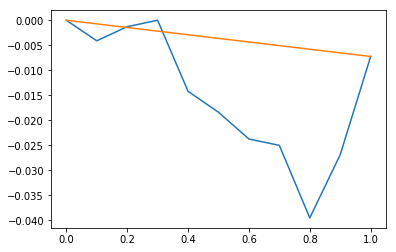

Best_params:  {'solver': 'liblinear'}


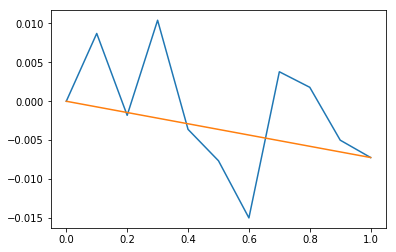

Best_params:  {'solver': 'liblinear'}


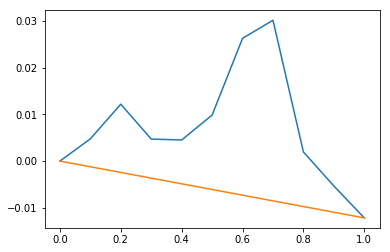

Best_params:  {'solver': 'liblinear'}


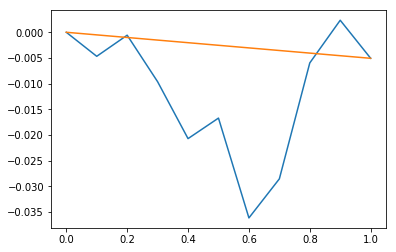

Best_params:  {'solver': 'liblinear'}


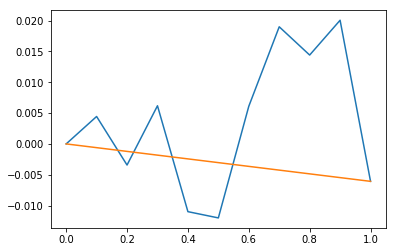

Best_params:  {'solver': 'liblinear'}
Method: <function tma at 0x7f55f5bb4a60>
search space: {'solver': ['liblinear']}
Qini values:  [-0.012048138779491818, 0.0024214056097827154, 0.014363854919523647, -0.009778923034165147, 0.007105547089242782]
    mean: 0.0004127491609784359, std: 0.01002602121603815
Qini 30 values:  [-0.00021360628618693204, 0.0015376654259718775, 0.002474570053718048, -0.0007778027187405443, 0.0006840259843110876]
    mean: 0.0007409704918147073, std: 0.0011714283440550923
Qini 10 values:  [-0.0001689412737799836, 0.0004720843672456576, 0.0002988409440022343, -0.00020857761550957958, 0.0002525607361672936]
    mean: 0.00012919343162512447, std: 0.00027001760937610405


In [0]:
#df = pd.read_csv('Hillstrom.csv')
#dataset = 'hillstrom'
df = pd.read_csv('criteo_small_fix.csv')
dataset = 'criteo'
df = preprocess_data(df, dataset=dataset)
Y = df['Y']
T = df['T']
X = df.drop(['Y', 'T'], axis=1)
ty = pd.DataFrame({'Y': Y, 'T': T})\
         .apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)


### Experiment procedure ###
# search_space = {
#     'ntree': [10, ],
#     'mtry': [3, ],
#     'bagging_fraction': [0.6, ],
#     'method': ['ED',],
#     'max_depth': [10, ],
#     'min_split': [1000, ],
#     'min_bucket_t0': [100,],
#     'min_bucket_t1': [100,],
# }
# method = upliftRF
# predict_method = predict_upliftRF

search_space = {
    'solver': ['liblinear',],
}
method = tma
predict_method = predict_tma

#search_space = {
#     'learning_rate': [0.1,],
#}
#method = dta
#predict_method = predict_dta

q_list = []
q_30_list = []
q_10_list = []
fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)
for idx, (train_index, test_index) in enumerate(fold_gen):
    X_train = X.reindex(train_index)
    X_test = X.reindex(test_index)
    Y_train = Y.reindex(train_index)
    Y_test = Y.reindex(test_index)
    T_train = T.reindex(train_index)
    T_test = T.reindex(test_index)

    df = X_train.copy()
    df['Y'] = Y_train
    df['T'] = T_train
    stratify = T_train
    if dataset == 'hillstrom':
        stratify = df[['Y', 'T']]
    tuning_df, validate_df = train_test_split(
        df, test_size=0.33, random_state=1234, stratify=stratify)

    X_tuning = tuning_df.drop(['Y', 'T'], axis=1)
    Y_tuning = tuning_df['Y']
    T_tuning = tuning_df['T']
    X_validate = validate_df.drop(['Y', 'T'], axis=1)
    Y_validate = validate_df['Y']
    T_validate = validate_df['T']
    data_dict = {
        "x_train": X_tuning,
        "y_train": Y_tuning,
        "t_train": T_tuning,
        "x_test": X_validate,
        "y_test": Y_validate,
        "t_test": T_validate,
    }

    _, best_params = parameter_tuning(method, predict_method, data_dict, 
                                      search_space=search_space, plotit=False)
    best_params = {k:v[0] for k, v in search_space.items()}
    trained_model = method(X_train, Y_train, T_train, **best_params)
    pred = predict_method(trained_model, X_test, y=Y_test, t=T_test)
    perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
    q = qini(perf)
    q_list.append(q)
    print("Best_params: ", best_params)
print("Method: {}".format(method))
print("search space:", search_space)
qini_list = [q['qini'] for q in q_list]
qini_30_list = [q['qini_30p'] for q in q_list]
qini_10_list = [q['qini_10p'] for q in q_list]
print('Qini values: ', qini_list)
print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))
print('Qini 30 values: ', qini_30_list)
print('    mean: {}, std: {}'.format(np.mean(qini_30_list), np.std(qini_30_list)))
print('Qini 10 values: ', qini_10_list)
print('    mean: {}, std: {}'.format(np.mean(qini_10_list), np.std(qini_10_list)))


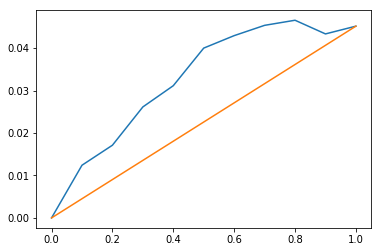

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'ED', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


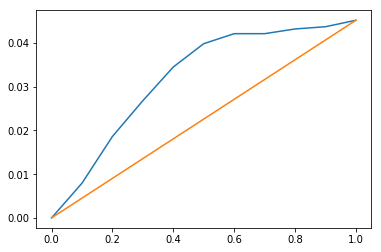

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'ED', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


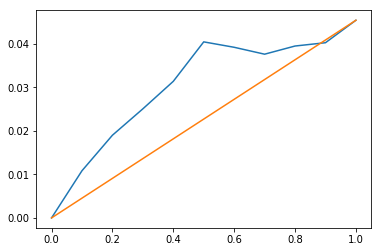

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'ED', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


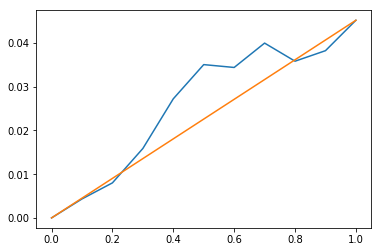

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'ED', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


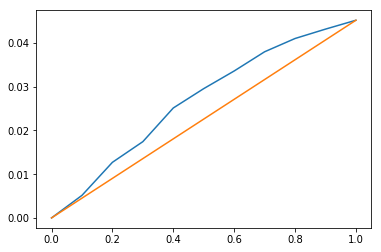

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'ED', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}
Method: <function upliftRF at 0x7f2a3465bbf8>
search space: {'ntree': [10], 'mtry': [3], 'bagging_fraction': [0.6], 'method': ['ED'], 'max_depth': [10], 'min_split': [1000], 'min_bucket_t0': [100], 'min_bucket_t1': [100]}
Qini values:  [0.010179119053795899, 0.0095460524117493, 0.007888231177538948, 0.003556775944968081, 0.004239862897883705]
    mean: 0.007082008297187187, std: 0.0027136196261792647
Qini 30 values:  [0.0022284969718562786, 0.0019612456019987463, 0.0021919639937389877, -5.009467304760255e-06, 0.0006253863203290371]
    mean: 0.001400416684123658, std: 0.0009168083674725123
Qini 10 values:  [0.0003947666607984957, 0.0001708385179443256, 0.00031476847107789565, -9.005475179705045e-06, 3.201348596639669e-05]
    mean: 0.00018067633212148171, std: 0.00015619986107464845


In [0]:
df = pd.read_csv('Hillstrom.csv')
dataset = 'hillstrom'
# df = pd.read_csv('criteo_small_fix.csv')
# dataset = 'criteo'
df = preprocess_data(df, dataset=dataset)
Y = df['Y']
T = df['T']
X = df.drop(['Y', 'T'], axis=1)
ty = pd.DataFrame({'Y': Y, 'T': T})\
         .apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)


### Experiment procedure ###
search_space = {
     'ntree': [10, ],
     'mtry': [3, ],
     'bagging_fraction': [0.6, ],
     'method': ['ED',],
     'max_depth': [10, ],
     'min_split': [1000, ],
     'min_bucket_t0': [100,],
     'min_bucket_t1': [100,],
 }
method = upliftRF
predict_method = predict_upliftRF

#search_space = {
#    'solver': ['liblinear',],
#}
#method = glai
#predict_method = predict_glai

#search_space = {
#     'learning_rate': [0.1,],
#}
#method = dta
#predict_method = predict_dta

q_list = []
q_30_list = []
q_10_list = []
fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)
for idx, (train_index, test_index) in enumerate(fold_gen):
    X_train = X.reindex(train_index)
    X_test = X.reindex(test_index)
    Y_train = Y.reindex(train_index)
    Y_test = Y.reindex(test_index)
    T_train = T.reindex(train_index)
    T_test = T.reindex(test_index)

    df = X_train.copy()
    df['Y'] = Y_train
    df['T'] = T_train
    stratify = T_train
    if dataset == 'hillstrom':
        stratify = df[['Y', 'T']]
    tuning_df, validate_df = train_test_split(
        df, test_size=0.33, random_state=1234, stratify=stratify)

    X_tuning = tuning_df.drop(['Y', 'T'], axis=1)
    Y_tuning = tuning_df['Y']
    T_tuning = tuning_df['T']
    X_validate = validate_df.drop(['Y', 'T'], axis=1)
    Y_validate = validate_df['Y']
    T_validate = validate_df['T']
    data_dict = {
        "x_train": X_tuning,
        "y_train": Y_tuning,
        "t_train": T_tuning,
        "x_test": X_validate,
        "y_test": Y_validate,
        "t_test": T_validate,
    }

    _, best_params = parameter_tuning(method, predict_method, data_dict, 
                                      search_space=search_space, plotit=False)
    best_params = {k:v[0] for k, v in search_space.items()}
    trained_model = method(X_train, Y_train, T_train, **best_params)
    pred = predict_method(trained_model, X_test, y=Y_test, t=T_test)
    perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
    q = qini(perf)
    q_list.append(q)
    print("Best_params: ", best_params)
print("Method: {}".format(method))
print("search space:", search_space)
qini_list = [q['qini'] for q in q_list]
qini_30_list = [q['qini_30p'] for q in q_list]
qini_10_list = [q['qini_10p'] for q in q_list]
print('Qini values: ', qini_list)
print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))
print('Qini 30 values: ', qini_30_list)
print('    mean: {}, std: {}'.format(np.mean(qini_30_list), np.std(qini_30_list)))
print('Qini 10 values: ', qini_10_list)
print('    mean: {}, std: {}'.format(np.mean(qini_10_list), np.std(qini_10_list)))


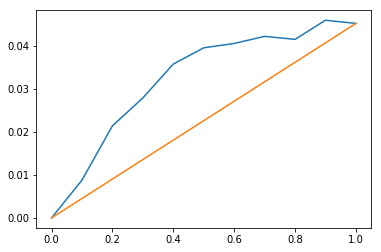

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'KL', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


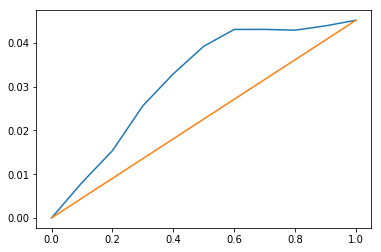

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'KL', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


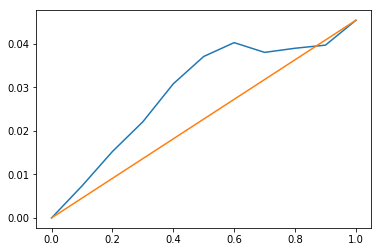

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'KL', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


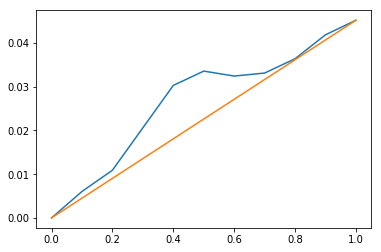

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'KL', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


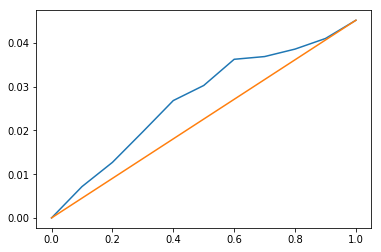

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'KL', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}
Method: <function upliftRF at 0x7f2a3465bbf8>
search space: {'ntree': [10], 'mtry': [3], 'bagging_fraction': [0.6], 'method': ['KL'], 'max_depth': [10], 'min_split': [1000], 'min_bucket_t0': [100], 'min_bucket_t1': [100]}
Qini values:  [0.010008390703596631, 0.009088663806730027, 0.006516133758417784, 0.004183893093969743, 0.0046090716465307935]
    mean: 0.006881230601848995, std: 0.002333389093601923
Qini 30 values:  [0.002377777864147129, 0.0015920429845891278, 0.001319521645333257, 0.0006909356677613286, 0.0009378603769246499]
    mean: 0.0013836277077510985, std: 0.0005855615806758108
Qini 10 values:  [0.0002132426074706751, 0.00017776275287794037, 0.00014018532057328846, 7.633040246890556e-05, 0.00013211524898670656]
    mean: 0.0001479272664755032, std: 4.602677172512464e-05


In [0]:
df = pd.read_csv('Hillstrom.csv')
dataset = 'hillstrom'
# df = pd.read_csv('criteo_small_fix.csv')
# dataset = 'criteo'
df = preprocess_data(df, dataset=dataset)
Y = df['Y']
T = df['T']
X = df.drop(['Y', 'T'], axis=1)
ty = pd.DataFrame({'Y': Y, 'T': T})\
         .apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)


### Experiment procedure ###
search_space = {
     'ntree': [10, ],
     'mtry': [3, ],
     'bagging_fraction': [0.6, ],
     'method': ['KL',],
     'max_depth': [10, ],
     'min_split': [1000, ],
     'min_bucket_t0': [100,],
     'min_bucket_t1': [100,],
 }
method = upliftRF
predict_method = predict_upliftRF

#search_space = {
#    'solver': ['liblinear',],
#}
#method = glai
#predict_method = predict_glai

#search_space = {
#     'learning_rate': [0.1,],
#}
#method = dta
#predict_method = predict_dta

q_list = []
q_30_list = []
q_10_list = []
fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)
for idx, (train_index, test_index) in enumerate(fold_gen):
    X_train = X.reindex(train_index)
    X_test = X.reindex(test_index)
    Y_train = Y.reindex(train_index)
    Y_test = Y.reindex(test_index)
    T_train = T.reindex(train_index)
    T_test = T.reindex(test_index)

    df = X_train.copy()
    df['Y'] = Y_train
    df['T'] = T_train
    stratify = T_train
    if dataset == 'hillstrom':
        stratify = df[['Y', 'T']]
    tuning_df, validate_df = train_test_split(
        df, test_size=0.33, random_state=1234, stratify=stratify)

    X_tuning = tuning_df.drop(['Y', 'T'], axis=1)
    Y_tuning = tuning_df['Y']
    T_tuning = tuning_df['T']
    X_validate = validate_df.drop(['Y', 'T'], axis=1)
    Y_validate = validate_df['Y']
    T_validate = validate_df['T']
    data_dict = {
        "x_train": X_tuning,
        "y_train": Y_tuning,
        "t_train": T_tuning,
        "x_test": X_validate,
        "y_test": Y_validate,
        "t_test": T_validate,
    }

    _, best_params = parameter_tuning(method, predict_method, data_dict, 
                                      search_space=search_space, plotit=False)
    best_params = {k:v[0] for k, v in search_space.items()}
    trained_model = method(X_train, Y_train, T_train, **best_params)
    pred = predict_method(trained_model, X_test, y=Y_test, t=T_test)
    perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
    q = qini(perf)
    q_list.append(q)
    print("Best_params: ", best_params)
print("Method: {}".format(method))
print("search space:", search_space)
qini_list = [q['qini'] for q in q_list]
qini_30_list = [q['qini_30p'] for q in q_list]
qini_10_list = [q['qini_10p'] for q in q_list]
print('Qini values: ', qini_list)
print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))
print('Qini 30 values: ', qini_30_list)
print('    mean: {}, std: {}'.format(np.mean(qini_30_list), np.std(qini_30_list)))
print('Qini 10 values: ', qini_10_list)
print('    mean: {}, std: {}'.format(np.mean(qini_10_list), np.std(qini_10_list)))


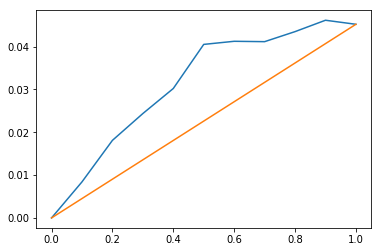

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'INT', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


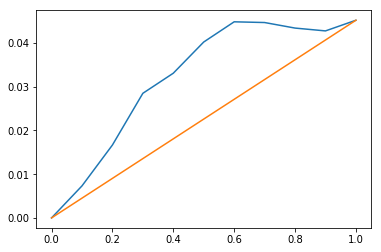

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'INT', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


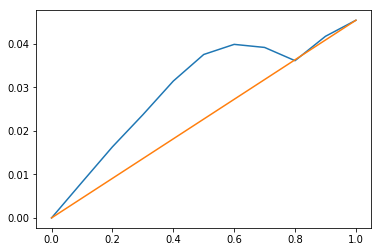

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'INT', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


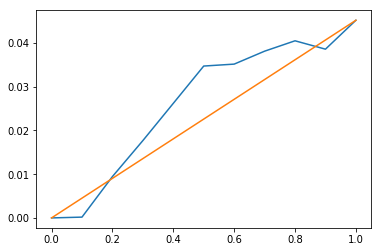

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'INT', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


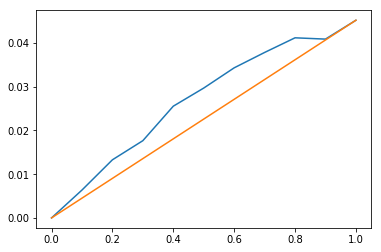

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'INT', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}
Method: <function upliftRF at 0x7f2a3465bbf8>
search space: {'ntree': [10], 'mtry': [3], 'bagging_fraction': [0.6], 'method': ['INT'], 'max_depth': [10], 'min_split': [1000], 'min_bucket_t0': [100], 'min_bucket_t1': [100]}
Qini values:  [0.009017363027800797, 0.009804895185656498, 0.0069700172295932145, 0.003721153094809148, 0.0043392364495696]
    mean: 0.006770532997485851, std: 0.0024292103131570283
Qini 30 values:  [0.001835234443201818, 0.001788904766572712, 0.0015929792563698173, -0.00018649974199463513, 0.0008154733926813611]
    mean: 0.0011692184233662146, std: 0.000770748861412824
Qini 10 values:  [0.00019458429678348302, 0.00014005280676812197, 0.00018262459095224695, -0.00021692973665651496, 9.27215472654859e-05]
    mean: 7.861070102256458e-05, std: 0.00015204417966874136


In [0]:
df = pd.read_csv('Hillstrom.csv')
dataset = 'hillstrom'
# df = pd.read_csv('criteo_small_fix.csv')
# dataset = 'criteo'
df = preprocess_data(df, dataset=dataset)
Y = df['Y']
T = df['T']
X = df.drop(['Y', 'T'], axis=1)
ty = pd.DataFrame({'Y': Y, 'T': T})\
         .apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)


### Experiment procedure ###
search_space = {
     'ntree': [10, ],
     'mtry': [3, ],
     'bagging_fraction': [0.6, ],
     'method': ['INT',],
     'max_depth': [10, ],
     'min_split': [1000, ],
     'min_bucket_t0': [100,],
     'min_bucket_t1': [100,],
 }
method = upliftRF
predict_method = predict_upliftRF

#search_space = {
#    'solver': ['liblinear',],
#}
#method = glai
#predict_method = predict_glai

#search_space = {
#     'learning_rate': [0.1,],
#}
#method = dta
#predict_method = predict_dta

q_list = []
q_30_list = []
q_10_list = []
fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)
for idx, (train_index, test_index) in enumerate(fold_gen):
    X_train = X.reindex(train_index)
    X_test = X.reindex(test_index)
    Y_train = Y.reindex(train_index)
    Y_test = Y.reindex(test_index)
    T_train = T.reindex(train_index)
    T_test = T.reindex(test_index)

    df = X_train.copy()
    df['Y'] = Y_train
    df['T'] = T_train
    stratify = T_train
    if dataset == 'hillstrom':
        stratify = df[['Y', 'T']]
    tuning_df, validate_df = train_test_split(
        df, test_size=0.33, random_state=1234, stratify=stratify)

    X_tuning = tuning_df.drop(['Y', 'T'], axis=1)
    Y_tuning = tuning_df['Y']
    T_tuning = tuning_df['T']
    X_validate = validate_df.drop(['Y', 'T'], axis=1)
    Y_validate = validate_df['Y']
    T_validate = validate_df['T']
    data_dict = {
        "x_train": X_tuning,
        "y_train": Y_tuning,
        "t_train": T_tuning,
        "x_test": X_validate,
        "y_test": Y_validate,
        "t_test": T_validate,
    }

    _, best_params = parameter_tuning(method, predict_method, data_dict, 
                                      search_space=search_space, plotit=False)
    best_params = {k:v[0] for k, v in search_space.items()}
    trained_model = method(X_train, Y_train, T_train, **best_params)
    pred = predict_method(trained_model, X_test, y=Y_test, t=T_test)
    perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
    q = qini(perf)
    q_list.append(q)
    print("Best_params: ", best_params)
print("Method: {}".format(method))
print("search space:", search_space)
qini_list = [q['qini'] for q in q_list]
qini_30_list = [q['qini_30p'] for q in q_list]
qini_10_list = [q['qini_10p'] for q in q_list]
print('Qini values: ', qini_list)
print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))
print('Qini 30 values: ', qini_30_list)
print('    mean: {}, std: {}'.format(np.mean(qini_30_list), np.std(qini_30_list)))
print('Qini 10 values: ', qini_10_list)
print('    mean: {}, std: {}'.format(np.mean(qini_10_list), np.std(qini_10_list)))


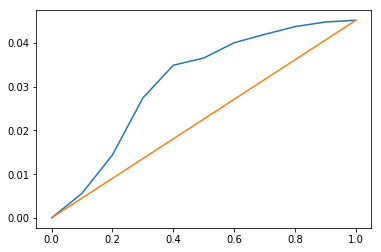

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'CHISQ', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


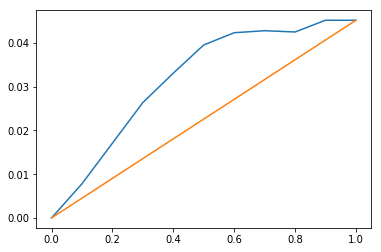

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'CHISQ', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


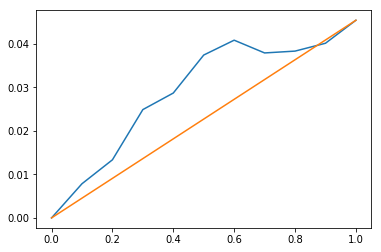

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'CHISQ', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


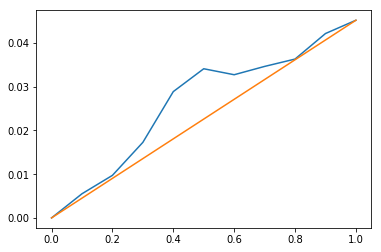

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'CHISQ', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}


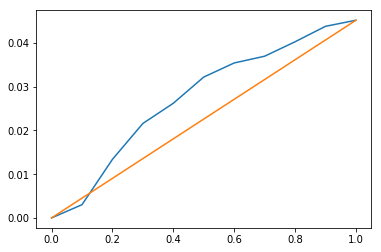

Best_params:  {'ntree': 10, 'mtry': 3, 'bagging_fraction': 0.6, 'method': 'CHISQ', 'max_depth': 10, 'min_split': 1000, 'min_bucket_t0': 100, 'min_bucket_t1': 100}
Method: <function upliftRF at 0x7f2a3465bbf8>
search space: {'ntree': [10], 'mtry': [3], 'bagging_fraction': [0.6], 'method': ['CHISQ'], 'max_depth': [10], 'min_split': [1000], 'min_bucket_t0': [100], 'min_bucket_t1': [100]}
Qini values:  [0.008604977657843443, 0.009339409343858844, 0.006499163332759253, 0.003797930631741102, 0.004951204880923155]
    mean: 0.00663853716942516, std: 0.002102244491833558
Qini 30 values:  [0.0013381955080422094, 0.0017741641523881567, 0.0013201391757897965, 0.00035498910721749356, 0.0006862757663660362]
    mean: 0.0010947527419607386, std: 0.0005071029411096101
Qini 10 values:  [5.5107829305957876e-05, 0.00016444278722893926, 0.00016545977123426047, 5.013430976653143e-05, -7.50360376310568e-05]
    mean: 7.202173198092644e-05, std: 8.906564499379598e-05


In [0]:
df = pd.read_csv('Hillstrom.csv')
dataset = 'hillstrom'
# df = pd.read_csv('criteo_small_fix.csv')
# dataset = 'criteo'
df = preprocess_data(df, dataset=dataset)
Y = df['Y']
T = df['T']
X = df.drop(['Y', 'T'], axis=1)
ty = pd.DataFrame({'Y': Y, 'T': T})\
         .apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)


### Experiment procedure ###
search_space = {
     'ntree': [10, ],
     'mtry': [3, ],
     'bagging_fraction': [0.6, ],
     'method': ['CHISQ',],
     'max_depth': [10, ],
     'min_split': [1000, ],
     'min_bucket_t0': [100,],
     'min_bucket_t1': [100,],
 }
method = upliftRF
predict_method = predict_upliftRF

#search_space = {
#    'solver': ['liblinear',],
#}
#method = glai
#predict_method = predict_glai

#search_space = {
#     'learning_rate': [0.1,],
#}
#method = dta
#predict_method = predict_dta

q_list = []
q_30_list = []
q_10_list = []
fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)
for idx, (train_index, test_index) in enumerate(fold_gen):
    X_train = X.reindex(train_index)
    X_test = X.reindex(test_index)
    Y_train = Y.reindex(train_index)
    Y_test = Y.reindex(test_index)
    T_train = T.reindex(train_index)
    T_test = T.reindex(test_index)

    df = X_train.copy()
    df['Y'] = Y_train
    df['T'] = T_train
    stratify = T_train
    if dataset == 'hillstrom':
        stratify = df[['Y', 'T']]
    tuning_df, validate_df = train_test_split(
        df, test_size=0.33, random_state=1234, stratify=stratify)

    X_tuning = tuning_df.drop(['Y', 'T'], axis=1)
    Y_tuning = tuning_df['Y']
    T_tuning = tuning_df['T']
    X_validate = validate_df.drop(['Y', 'T'], axis=1)
    Y_validate = validate_df['Y']
    T_validate = validate_df['T']
    data_dict = {
        "x_train": X_tuning,
        "y_train": Y_tuning,
        "t_train": T_tuning,
        "x_test": X_validate,
        "y_test": Y_validate,
        "t_test": T_validate,
    }

    _, best_params = parameter_tuning(method, predict_method, data_dict, 
                                      search_space=search_space, plotit=False)
    best_params = {k:v[0] for k, v in search_space.items()}
    trained_model = method(X_train, Y_train, T_train, **best_params)
    pred = predict_method(trained_model, X_test, y=Y_test, t=T_test)
    perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
    q = qini(perf)
    q_list.append(q)
    print("Best_params: ", best_params)
print("Method: {}".format(method))
print("search space:", search_space)
qini_list = [q['qini'] for q in q_list]
qini_30_list = [q['qini_30p'] for q in q_list]
qini_10_list = [q['qini_10p'] for q in q_list]
print('Qini values: ', qini_list)
print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))
print('Qini 30 values: ', qini_30_list)
print('    mean: {}, std: {}'.format(np.mean(qini_30_list), np.std(qini_30_list)))
print('Qini 10 values: ', qini_10_list)
print('    mean: {}, std: {}'.format(np.mean(qini_10_list), np.std(qini_10_list)))


In [0]:
trained_model.classes_

NameError: ignored

In [0]:
from sklearn.ensemble import GradientBoostingClassifier


def z_assign(y, t):
    """ Define transformed response variable z
    if (treated and response) or (not treated and not response), return 1
    else, return 0
    """
    if y == 1 and t == 1:
        return 1
    elif y == 0 and t == 1:
        return 0
    elif y == 1 and t == 0:
        return 0
    elif y == 0 and t == 0:
        return 1
    else:
        return None


def lai(x, y, t, method=GradientBoostingClassifier, **kwargs):
    """Training a model according to the "Lai's Approach" 
    The default model is Gradient Boosting Machine (gbm)

    Source: "Influential Marketing" (Lai, 2006) and "Mining Truly Responsive
            Customers Using True Lift Overview" (Kane, 2014)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        t: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        A sklearn model.
    """
    df = pd.DataFrame({'y': y.copy()})
    df['t'] = t
    z = df.apply(lambda row: z_assign(row['y'], row['t']), axis=1)
    
    model = method(**kwargs).fit(x, z)
    
    return model


def predict_lai(obj, newdata, y, t, **kwargs):
    """Predictions according to the "Lai's Approach" 
    
    Source: "Influential Marketing" (Lai, 2006) and "Mining Truly Responsive
            Customers Using True Lift Overview" (Kane, 2014)

    Args:
        obj: A sklearn model.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        dataframe: A dataframe with predictions for when the instances are
            treated and for when they are not treated.
    """
    pred = obj.predict_proba(newdata)    # list of [False, True]

    res = pd.DataFrame({
        "pr_y1_t1": [row[1] for row in pred],
        "pr_y1_t0": [row[0] for row in pred],
    })
    return res


In [0]:
from sklearn.ensemble import GradientBoostingClassifier


def glai(x, y, t, method=GradientBoostingClassifier, **kwargs):
    """Training a model according to the "Lai's Approach" 
    The default model is Gradient Boosting Machine (gbm)

    Source: "Influential Marketing" (Lai, 2006) and "Mining Truly Responsive
            Customers Using True Lift Overview" (Kane, 2014)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        t: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        A sklearn model.
    """
    df = pd.DataFrame({'y': y.copy()})
    df['t'] = t
    ty = df.apply(lambda row: ty_assign(row['y'], row['t']), axis=1)
    
    model = method(**kwargs).fit(x, ty)
    
    return model


def predict_glai(obj, newdata, y, t, **kwargs):
    """Predictions according to the "Lai's Approach" 
    
    Source: "Influential Marketing" (Lai, 2006) and "Mining Truly Responsive
            Customers Using True Lift Overview" (Kane, 2014)

    Args:
        obj: A sklearn model.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        dataframe: A dataframe with predictions for when the instances are
            treated and for when they are not treated.
    """
    prob_T = sum(t) / len(t)
    prob_C = 1 - prob_T

    pred = obj.predict_proba(newdata)    # list of [CN, CR, TN, TR]

    res = pd.DataFrame({
        "pr_y1_t1": [row[3]/prob_T + row[0]/prob_C for row in pred],   # TR/T + CN/C
        "pr_y1_t0": [row[2]/prob_T + row[1]/prob_C for row in pred],   # TN/T + CR/C
    })
    return res


In [0]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


def z_assign(y, t):
    """ Define transformed response variable z
    if (treated and response) or (not treated and not response), return 1
    else, return 0
    """
    if y == 1 and t == 1:
        return 1
    elif y == 0 and t == 1:
        return 0
    elif y == 1 and t == 0:
        return 0
    elif y == 0 and t == 0:
        return 1
    else:
        return None




def rvtu(x, y, t, method=LogisticRegression, **kwargs):
    """Transforming the data according to the "Jaskowski's Approach"
    Sometimes, it called Response Variable Transformation for Uplift (RVTU)

    Source: "Uplift modeling for clinical trial data" (Jaskowski, 2006)
    """

    ### Combine x, y, and ct
    df = x.copy()
    df['y'] = y
    df['ct'] = t
    df['z'] = df.apply(lambda row: z_assign(row['y'], row['ct']), axis=1)
 
    mdl = method(**kwargs).fit(x, df['z'])
    
    return mdl


def predict_rvtu(obj, newdata, y, t, **kwargs):
    # df = pd.DataFrame({'y': y.copy()})
    # df['ct'] = ct
    # z = df.apply(lambda row: z_assign(row['y'], row['ct']), axis=1)

    if isinstance(obj, LinearRegression):
        pred = obj.predict(newdata)
    else:
        pred = obj.predict_proba(newdata)[:, 1]

    res = pd.DataFrame({
        "pr_y1_t1": [row for row in pred],
        "pr_y1_t0": [1-row for row in pred],
    })
    return res


In [0]:
from sklearn.linear_model import LogisticRegression
import pandas as pd


def dta(x, y, t, method=LogisticRegression, **kwargs):
    """Training a model according to the "Dummy Treatment Approach" 
    The default model is General Linear Model (GLM)

    Source: "The True Lift Model" (Lo, 2002)

    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        t: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a 
            multinominal class variable.

    Return:
        A sklearn model.
    """
    # Create interaction variables
    # Building our dataframe with the interaction variables
    df = x.copy()
    for colname in x.columns:
        df["Int_" + colname] = x[colname] * t
    df['treated'] = t

    # Fit a model
    model = method(**kwargs).fit(df, y)

    return model


def predict_dta(obj, newdata, y_name='y', t_name='treated', **kwargs):
    """Predictions according to the "Dummy Treatment Approach" 
    
    For each instance in newdata two predictions are made:
    1) What is the probability of a person responding when treated?
    2) What is the probability of a person responding when not treated
      (i.e. part of control group)?

    Source: "The True Lift Model" (Lo, 2002)

    Args:
        obj: A sklearn model.
        newdata: A data frame containing the values at which predictions
            are required.
    
    Return:
        dataframe: A dataframe with predictions for when the instances are
            treated and for when they are not treated.
    """
    predictors = [c for c in newdata.columns if c not in (y_name, t_name)]

    df_treat = newdata.copy()
    df_control = newdata.copy()
    for colname in predictors:
        df_treat["Int_" + colname] = df_treat[colname] * 1
        df_control["Int_" + colname] = df_control[colname] * 0
    df_treat['treated'] = 1
    df_control['treated'] = 0

    # print(obj.coef_, obj.intercept_)
    pred_treat = obj.predict_proba(df_treat)[:, 1]
    pred_control = obj.predict_proba(df_control)[:, 1]

    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df

